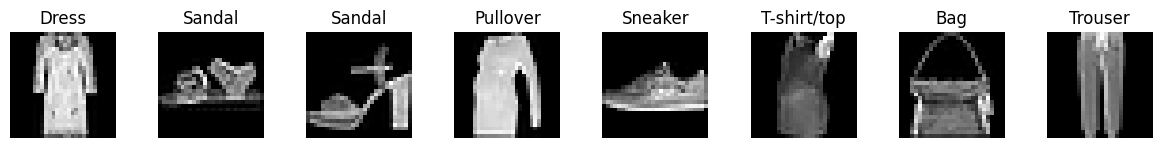

Epoch 1/30 - Loss: 1.5336
Epoch 2/30 - Loss: 0.8034
Epoch 3/30 - Loss: 0.6671
Epoch 4/30 - Loss: 0.5936
Epoch 5/30 - Loss: 0.5471
Epoch 6/30 - Loss: 0.5167
Epoch 7/30 - Loss: 0.4946
Epoch 8/30 - Loss: 0.4794
Epoch 9/30 - Loss: 0.4670
Epoch 10/30 - Loss: 0.4573
Epoch 11/30 - Loss: 0.4487
Epoch 12/30 - Loss: 0.4416
Epoch 13/30 - Loss: 0.4348
Epoch 14/30 - Loss: 0.4293
Epoch 15/30 - Loss: 0.4241
Epoch 16/30 - Loss: 0.4197
Epoch 17/30 - Loss: 0.4145
Epoch 18/30 - Loss: 0.4102
Epoch 19/30 - Loss: 0.4059
Epoch 20/30 - Loss: 0.4019
Epoch 21/30 - Loss: 0.3987
Epoch 22/30 - Loss: 0.3947
Epoch 23/30 - Loss: 0.3910
Epoch 24/30 - Loss: 0.3879
Epoch 25/30 - Loss: 0.3843
Epoch 26/30 - Loss: 0.3810
Epoch 27/30 - Loss: 0.3780
Epoch 28/30 - Loss: 0.3753
Epoch 29/30 - Loss: 0.3721
Epoch 30/30 - Loss: 0.3694

Validation Accuracy: 85.20%

True Label: Pullover
Predicted Label: Pullover
Confidence: 98.70%


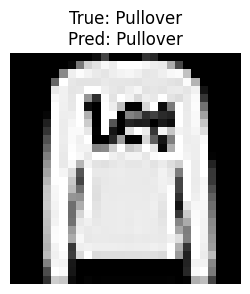

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# 1. DATA SETUP
# ============================================================================

RESIZE_DIMS = (28, 28)
DATA_ROOT = './data'
BATCH_SIZE = 64
FASHION_LABELS = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Create transforms and dataloaders
transform = transforms.Compose([
    transforms.Resize(RESIZE_DIMS),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.FashionMNIST(
    root=DATA_ROOT, train=True, transform=transform, download=True
)
val_dataset = torchvision.datasets.FashionMNIST(
    root=DATA_ROOT, train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ============================================================================
# 2. VISUALIZATION UTILITIES
# ============================================================================

def show_images_grid(imgs, nrows, ncols, titles=None, scale=1.5):
    """Display a grid of images."""
    imgs = imgs.cpu().numpy()
    if imgs.ndim == 4 and imgs.shape[1] == 1:
        imgs = imgs.squeeze(1)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * scale, nrows * scale))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(imgs):
            ax.imshow(imgs[i], cmap='gray')
            if titles:
                ax.set_title(titles[i])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize first batch
X, y = next(iter(train_loader))
batch_labels = [FASHION_LABELS[int(label)] for label in y[:8]]
show_images_grid(X[:8], 1, 8, titles=batch_labels)

# ============================================================================
# 3. MODEL TRAINING (Manual MLP)
# ============================================================================

# Initialize model parameters
lr = 0.01
W1 = torch.normal(0, 0.01, (784, 128), requires_grad=True)
b1 = torch.zeros(128, requires_grad=True)
W2 = torch.normal(0, 0.01, (128, 10), requires_grad=True)
b2 = torch.zeros(10, requires_grad=True)

losses = []
num_epochs = 30

for epoch in range(num_epochs):
    epoch_loss = 0
    
    for images, labels in train_loader:
        # Forward pass
        x = images.flatten(1)
        
        # Hidden layer with ReLU
        z1 = torch.matmul(x, W1) + b1
        h1 = torch.relu(z1)
        
        # Output layer
        logits = torch.matmul(h1, W2) + b2
        
        # Loss
        loss = F.cross_entropy(logits, labels)
        
        # Backward pass (manual)
        loss.backward()
        
        # Manual gradient update
        W1.data -= lr * W1.grad
        b1.data -= lr * b1.grad
        W2.data -= lr * W2.grad
        b2.data -= lr * b2.grad
        
        # Zero gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/30 - Loss: {avg_loss:.4f}")

# ============================================================================
# 4. VALIDATION & EVALUATION
# ============================================================================

def evaluate(loader, W1, b1, W2, b2):
    """Evaluate model accuracy on a dataset."""
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            x = images.flatten(1)
            
            # Forward pass
            z1 = torch.matmul(x, W1) + b1
            h1 = torch.relu(z1)
            logits = torch.matmul(h1, W2) + b2
            
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return (correct / total) * 100

val_accuracy = evaluate(val_loader, W1, b1, W2, b2)
print(f"\nValidation Accuracy: {val_accuracy:.2f}%")

# ============================================================================
# 5. SINGLE IMAGE PREDICTION
# ============================================================================

sample_image, true_label = val_dataset[1]
input_flat = sample_image.flatten().unsqueeze(0)

with torch.no_grad():
    # Forward pass
    z1 = torch.matmul(input_flat, W1) + b1
    h1 = torch.relu(z1)
    logits = torch.matmul(h1, W2) + b2
    probs = F.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1).item()

print(f"\nTrue Label: {FASHION_LABELS[true_label]}")
print(f"Predicted Label: {FASHION_LABELS[pred_label]}")
print(f"Confidence: {probs[0, pred_label]:.2%}")

# Visualize
plt.figure(figsize=(3, 3))
plt.imshow(sample_image.squeeze().numpy(), cmap='gray')
plt.title(f"True: {FASHION_LABELS[true_label]}\nPred: {FASHION_LABELS[pred_label]}")
plt.axis('off')
plt.show()